In [34]:
import pandas as pd
from database.adatabase import ADatabase
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
from tqdm import tqdm
from processor.processor import Processor as p
from asset.exposure import Exposure
from equations.capm import CAPM
from sklearn.preprocessing import normalize
from datetime import timedelta
import yfinance as yf
import warnings
from time import sleep
warnings.simplefilter(action="ignore")
from indicator.indicator import Indicator
from scipy.stats.mstats import winsorize

In [2]:
sec = ADatabase("sec")
market = ADatabase("market")
fred = ADatabase("fred")

In [3]:
market.connect()
index = market.retrieve("index")
market.disconnect()
factors = ["AMZN","NVDA","AAPL","META","GOOGL","TSLA","MSFT"]
fred.connect()
sp500 = p.column_date_processing(fred.retrieve("sp500_projections").rename(columns={"prediction":"sp500_prediction"}))
interest_rates = p.column_date_processing(fred.retrieve("market_yield").rename(columns={"value":"rf"}))
interest_rates["rf"] = interest_rates["rf"].replace(".",0)
interest_rates["rf"] = [float(x) / 100 for x in interest_rates["rf"]]
fred.disconnect
macro = sp500.merge(interest_rates,on="date",how="left")

In [4]:
market.connect()
factors_df = []
for ticker in tqdm(factors):
    try:
        price = p.column_date_processing(market.query("prices",{"ticker":ticker}))
        price.sort_values("date")
        price["adjclose"] = price["adjclose"].shift(60)
        factors_df.append(price)
    except Exception as e:
        print(ticker,str(e))
        continue
market.disconnect()
factors_df = pd.concat(factors_df).sort_values("date").pivot_table(index=["date"],columns="ticker",values="adjclose").reset_index()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 20.17it/s]


In [5]:
model_start = 2015
model_end = 2022
backtest_end = 2026

In [6]:
market.connect()
prices = []
for ticker in tqdm(index["ticker"]):
    try:
        price = p.column_date_processing(market.query("prices",{"ticker":ticker}))
        price.sort_values("date",inplace=True)
        price = factors_df.merge(price[["date","ticker","adjclose","high","low","volume"]],on="date",how="left")
        price = p.additional_date_cols(price)
        price["quarter"] = price["date"].dt.quarter
        price = Indicator.calculate_indicators(price)
        price["y"] = price["adjclose"].shift(-60)
        training_data = price[(price["year"]>=model_start) & (price["year"] < model_end)].dropna(subset=factors).dropna()
        sim = price[(price["year"]>=model_end-1) & (price["year"]<backtest_end)].dropna(subset=factors)
        model = XGBRegressor()
        model.fit(training_data[factors],training_data["y"])
        sim["prediction"] = model.predict(sim[factors])
        sim = sim.merge(macro,on="date",how="left")
        sim = CAPM.apply(sim)
        prices.append(sim)
    except Exception as e:
        print(str(e))
        continue
market.disconnect()

  0%|▍                                                                                                                                                       | 13/5121 [00:01<12:54,  6.60it/s]

index 0 is out of bounds for axis 0 with size 0
'date'


  0%|▌                                                                                                                                                       | 19/5121 [00:02<09:54,  8.59it/s]

'date'


  1%|▊                                                                                                                                                       | 28/5121 [00:03<09:45,  8.70it/s]

index 0 is out of bounds for axis 0 with size 0


  1%|█▏                                                                                                                                                      | 38/5121 [00:04<08:52,  9.54it/s]

'date'


  1%|█▉                                                                                                                                                      | 67/5121 [00:09<10:39,  7.90it/s]

index 0 is out of bounds for axis 0 with size 0


  2%|██▋                                                                                                                                                     | 91/5121 [00:12<12:54,  6.50it/s]

'date'


  2%|███                                                                                                                                                    | 102/5121 [00:14<10:07,  8.26it/s]

index 0 is out of bounds for axis 0 with size 0


  3%|███▉                                                                                                                                                   | 134/5121 [00:18<12:30,  6.65it/s]

index 0 is out of bounds for axis 0 with size 0


  3%|████▏                                                                                                                                                  | 141/5121 [00:19<09:50,  8.43it/s]

'date'


  3%|████▌                                                                                                                                                  | 154/5121 [00:21<10:27,  7.91it/s]

index 0 is out of bounds for axis 0 with size 0


  3%|████▋                                                                                                                                                  | 159/5121 [00:22<07:16, 11.36it/s]

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0


  4%|█████▋                                                                                                                                                 | 195/5121 [00:27<08:59,  9.14it/s]

index 0 is out of bounds for axis 0 with size 0


  6%|████████▊                                                                                                                                              | 297/5121 [00:42<09:01,  8.91it/s]

'date'


  8%|███████████▌                                                                                                                                           | 394/5121 [00:58<08:50,  8.91it/s]

index 0 is out of bounds for axis 0 with size 0


  9%|█████████████▊                                                                                                                                         | 468/5121 [01:10<12:49,  6.05it/s]

index 0 is out of bounds for axis 0 with size 0


 10%|██████████████▉                                                                                                                                        | 508/5121 [01:17<09:30,  8.08it/s]

index 0 is out of bounds for axis 0 with size 0


 10%|███████████████▊                                                                                                                                       | 535/5121 [01:21<11:44,  6.51it/s]

index 0 is out of bounds for axis 0 with size 0


 11%|████████████████▋                                                                                                                                      | 568/5121 [01:27<11:44,  6.46it/s]

index 0 is out of bounds for axis 0 with size 0


 11%|█████████████████                                                                                                                                      | 577/5121 [01:29<13:27,  5.63it/s]

index 0 is out of bounds for axis 0 with size 0


 11%|█████████████████                                                                                                                                      | 579/5121 [01:29<11:58,  6.32it/s]

'date'
'date'


 12%|█████████████████▊                                                                                                                                     | 602/5121 [01:33<09:50,  7.66it/s]

'date'


 12%|██████████████████▎                                                                                                                                    | 619/5121 [01:35<12:52,  5.83it/s]

'date'


 12%|██████████████████▍                                                                                                                                    | 625/5121 [01:36<08:01,  9.33it/s]

index 0 is out of bounds for axis 0 with size 0


 12%|██████████████████▌                                                                                                                                    | 630/5121 [01:37<08:26,  8.87it/s]

index 0 is out of bounds for axis 0 with size 0


 13%|███████████████████▋                                                                                                                                   | 668/5121 [01:43<09:55,  7.48it/s]

index 0 is out of bounds for axis 0 with size 0


 14%|████████████████████▍                                                                                                                                  | 695/5121 [01:48<09:48,  7.52it/s]

index 0 is out of bounds for axis 0 with size 0


 14%|█████████████████████▏                                                                                                                                 | 717/5121 [01:51<09:40,  7.58it/s]

index 0 is out of bounds for axis 0 with size 0


 14%|█████████████████████▏                                                                                                                                 | 719/5121 [01:51<09:46,  7.51it/s]

'date'
'date'


 16%|████████████████████████                                                                                                                               | 814/5121 [02:06<11:54,  6.03it/s]

index 0 is out of bounds for axis 0 with size 0


 16%|████████████████████████▍                                                                                                                              | 829/5121 [02:09<12:37,  5.67it/s]

index 0 is out of bounds for axis 0 with size 0


 16%|████████████████████████▉                                                                                                                              | 844/5121 [02:11<09:45,  7.31it/s]

index 0 is out of bounds for axis 0 with size 0


 17%|█████████████████████████▌                                                                                                                             | 868/5121 [02:15<08:23,  8.44it/s]

index 0 is out of bounds for axis 0 with size 0


 17%|██████████████████████████▎                                                                                                                            | 894/5121 [02:19<08:09,  8.64it/s]

'date'


 18%|██████████████████████████▊                                                                                                                            | 910/5121 [02:21<09:31,  7.37it/s]

index 0 is out of bounds for axis 0 with size 0


 18%|███████████████████████████▏                                                                                                                           | 922/5121 [02:24<13:16,  5.27it/s]

index 0 is out of bounds for axis 0 with size 0


 18%|███████████████████████████▋                                                                                                                           | 939/5121 [02:26<06:59,  9.96it/s]

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0


 19%|█████████████████████████████                                                                                                                          | 986/5121 [02:34<09:00,  7.65it/s]

index 0 is out of bounds for axis 0 with size 0


 20%|█████████████████████████████▍                                                                                                                        | 1003/5121 [02:37<13:02,  5.26it/s]

'date'


 21%|██████████████████████████████▉                                                                                                                       | 1055/5121 [02:46<11:03,  6.13it/s]

index 0 is out of bounds for axis 0 with size 0


 21%|███████████████████████████████▉                                                                                                                      | 1090/5121 [02:52<09:02,  7.43it/s]

'date'


 21%|████████████████████████████████                                                                                                                      | 1095/5121 [02:53<12:44,  5.26it/s]

index 0 is out of bounds for axis 0 with size 0


 22%|█████████████████████████████████▍                                                                                                                    | 1143/5121 [03:00<08:43,  7.60it/s]

'date'
'date'


 23%|██████████████████████████████████▌                                                                                                                   | 1179/5121 [03:06<12:22,  5.31it/s]

index 0 is out of bounds for axis 0 with size 0


 25%|████████████████████████████████████▉                                                                                                                 | 1260/5121 [03:20<08:58,  7.17it/s]

'date'


 25%|█████████████████████████████████████▎                                                                                                                | 1272/5121 [03:22<11:16,  5.69it/s]

index 0 is out of bounds for axis 0 with size 0


 26%|██████████████████████████████████████▊                                                                                                               | 1327/5121 [03:32<07:35,  8.33it/s]

index 0 is out of bounds for axis 0 with size 0


 26%|███████████████████████████████████████                                                                                                               | 1335/5121 [03:33<13:08,  4.80it/s]

index 0 is out of bounds for axis 0 with size 0


 27%|████████████████████████████████████████                                                                                                              | 1368/5121 [03:39<11:21,  5.51it/s]

index 0 is out of bounds for axis 0 with size 0


 27%|████████████████████████████████████████▏                                                                                                             | 1371/5121 [03:40<11:11,  5.58it/s]

index 0 is out of bounds for axis 0 with size 0


 27%|████████████████████████████████████████▉                                                                                                             | 1399/5121 [03:44<07:56,  7.82it/s]

index 0 is out of bounds for axis 0 with size 0


 28%|██████████████████████████████████████████▎                                                                                                           | 1446/5121 [03:51<08:21,  7.33it/s]

index 0 is out of bounds for axis 0 with size 0


 28%|██████████████████████████████████████████▍                                                                                                           | 1450/5121 [03:52<08:13,  7.44it/s]

index 0 is out of bounds for axis 0 with size 0


 29%|██████████████████████████████████████████▉                                                                                                           | 1465/5121 [03:54<08:55,  6.83it/s]

index 0 is out of bounds for axis 0 with size 0


 29%|███████████████████████████████████████████▉                                                                                                          | 1502/5121 [04:00<07:30,  8.04it/s]

index 0 is out of bounds for axis 0 with size 0


 30%|████████████████████████████████████████████▍                                                                                                         | 1518/5121 [04:03<12:52,  4.67it/s]

index 0 is out of bounds for axis 0 with size 0


 30%|████████████████████████████████████████████▊                                                                                                         | 1530/5121 [04:05<06:03,  9.87it/s]

'date'


 31%|██████████████████████████████████████████████                                                                                                        | 1574/5121 [04:13<07:35,  7.78it/s]

index 0 is out of bounds for axis 0 with size 0


 32%|████████████████████████████████████████████████▎                                                                                                     | 1650/5121 [04:25<07:36,  7.61it/s]

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0


 33%|████████████████████████████████████████████████▊                                                                                                     | 1666/5121 [04:28<08:11,  7.04it/s]

index 0 is out of bounds for axis 0 with size 0


 33%|█████████████████████████████████████████████████                                                                                                     | 1676/5121 [04:30<09:37,  5.97it/s]

index 0 is out of bounds for axis 0 with size 0
'date'


 34%|██████████████████████████████████████████████████▊                                                                                                   | 1733/5121 [04:40<07:51,  7.19it/s]

index 0 is out of bounds for axis 0 with size 0


 34%|███████████████████████████████████████████████████▍                                                                                                  | 1754/5121 [04:43<11:38,  4.82it/s]

index 0 is out of bounds for axis 0 with size 0


 34%|███████████████████████████████████████████████████▋                                                                                                  | 1765/5121 [04:45<09:43,  5.75it/s]

index 0 is out of bounds for axis 0 with size 0


 35%|████████████████████████████████████████████████████▏                                                                                                 | 1781/5121 [04:47<07:15,  7.68it/s]

index 0 is out of bounds for axis 0 with size 0


 36%|██████████████████████████████████████████████████████▋                                                                                               | 1869/5121 [05:04<08:12,  6.60it/s]

index 0 is out of bounds for axis 0 with size 0


 37%|███████████████████████████████████████████████████████▊                                                                                              | 1904/5121 [05:10<07:18,  7.33it/s]

index 0 is out of bounds for axis 0 with size 0


 38%|████████████████████████████████████████████████████████▎                                                                                             | 1924/5121 [05:12<06:14,  8.55it/s]

'date'


 38%|████████████████████████████████████████████████████████▍                                                                                             | 1926/5121 [05:13<06:41,  7.95it/s]

index 0 is out of bounds for axis 0 with size 0


 38%|█████████████████████████████████████████████████████████▌                                                                                            | 1964/5121 [05:19<08:01,  6.55it/s]

index 0 is out of bounds for axis 0 with size 0


 39%|██████████████████████████████████████████████████████████▎                                                                                           | 1991/5121 [05:23<06:36,  7.89it/s]

index 0 is out of bounds for axis 0 with size 0


 40%|███████████████████████████████████████████████████████████▉                                                                                          | 2045/5121 [05:32<05:39,  9.05it/s]

index 0 is out of bounds for axis 0 with size 0


 40%|████████████████████████████████████████████████████████████▍                                                                                         | 2062/5121 [05:35<06:22,  8.00it/s]

index 0 is out of bounds for axis 0 with size 0


 40%|████████████████████████████████████████████████████████████▌                                                                                         | 2068/5121 [05:36<08:33,  5.95it/s]

index 0 is out of bounds for axis 0 with size 0


 40%|████████████████████████████████████████████████████████████▋                                                                                         | 2074/5121 [05:37<07:55,  6.41it/s]

'date'


 41%|█████████████████████████████████████████████████████████████▊                                                                                        | 2111/5121 [05:43<07:14,  6.93it/s]

index 0 is out of bounds for axis 0 with size 0


 41%|█████████████████████████████████████████████████████████████▉                                                                                        | 2115/5121 [05:44<08:48,  5.69it/s]

index 0 is out of bounds for axis 0 with size 0


 41%|██████████████████████████████████████████████████████████████▏                                                                                       | 2125/5121 [05:45<09:07,  5.47it/s]

'date'


 42%|██████████████████████████████████████████████████████████████▉                                                                                       | 2148/5121 [05:49<06:59,  7.09it/s]

index 0 is out of bounds for axis 0 with size 0


 42%|███████████████████████████████████████████████████████████████                                                                                       | 2152/5121 [05:50<05:46,  8.57it/s]

index 0 is out of bounds for axis 0 with size 0


 42%|███████████████████████████████████████████████████████████████▍                                                                                      | 2166/5121 [05:52<06:51,  7.18it/s]

index 0 is out of bounds for axis 0 with size 0


 43%|████████████████████████████████████████████████████████████████▋                                                                                     | 2209/5121 [06:00<09:34,  5.07it/s]

'date'


 43%|████████████████████████████████████████████████████████████████▉                                                                                     | 2218/5121 [06:01<06:21,  7.61it/s]

index 0 is out of bounds for axis 0 with size 0


 43%|█████████████████████████████████████████████████████████████████                                                                                     | 2221/5121 [06:01<08:57,  5.39it/s]

index 0 is out of bounds for axis 0 with size 0


 44%|█████████████████████████████████████████████████████████████████▊                                                                                    | 2245/5121 [06:05<09:11,  5.22it/s]

index 0 is out of bounds for axis 0 with size 0


 44%|█████████████████████████████████████████████████████████████████▊                                                                                    | 2247/5121 [06:06<08:13,  5.83it/s]

'date'


 46%|████████████████████████████████████████████████████████████████████▉                                                                                 | 2354/5121 [06:23<06:13,  7.42it/s]

index 0 is out of bounds for axis 0 with size 0


 46%|█████████████████████████████████████████████████████████████████████                                                                                 | 2359/5121 [06:24<05:24,  8.51it/s]

index 0 is out of bounds for axis 0 with size 0


 46%|█████████████████████████████████████████████████████████████████████▎                                                                                | 2368/5121 [06:25<06:46,  6.76it/s]

index 0 is out of bounds for axis 0 with size 0


 46%|█████████████████████████████████████████████████████████████████████▍                                                                                | 2372/5121 [06:26<07:53,  5.81it/s]

'date'


 48%|███████████████████████████████████████████████████████████████████████▉                                                                              | 2454/5121 [06:39<07:39,  5.81it/s]

index 0 is out of bounds for axis 0 with size 0


 48%|████████████████████████████████████████████████████████████████████████▌                                                                             | 2476/5121 [06:43<05:26,  8.09it/s]

index 0 is out of bounds for axis 0 with size 0


 49%|█████████████████████████████████████████████████████████████████████████▏                                                                            | 2497/5121 [06:46<04:27,  9.81it/s]

index 0 is out of bounds for axis 0 with size 0


 49%|█████████████████████████████████████████████████████████████████████████▊                                                                            | 2520/5121 [06:50<05:21,  8.09it/s]

index 0 is out of bounds for axis 0 with size 0


 49%|██████████████████████████████████████████████████████████████████████████▏                                                                           | 2531/5121 [06:52<08:35,  5.03it/s]

index 0 is out of bounds for axis 0 with size 0


 50%|██████████████████████████████████████████████████████████████████████████▉                                                                           | 2559/5121 [06:56<08:09,  5.24it/s]

index 0 is out of bounds for axis 0 with size 0


 50%|███████████████████████████████████████████████████████████████████████████▏                                                                          | 2568/5121 [06:58<06:59,  6.08it/s]

index 0 is out of bounds for axis 0 with size 0


 50%|███████████████████████████████████████████████████████████████████████████▋                                                                          | 2586/5121 [07:01<08:41,  4.86it/s]

index 0 is out of bounds for axis 0 with size 0


 52%|██████████████████████████████████████████████████████████████████████████████                                                                        | 2663/5121 [07:14<07:01,  5.83it/s]

'date'


 52%|██████████████████████████████████████████████████████████████████████████████▌                                                                       | 2682/5121 [07:17<03:40, 11.07it/s]

'date'
'date'


 53%|███████████████████████████████████████████████████████████████████████████████▊                                                                      | 2726/5121 [07:24<08:18,  4.81it/s]

index 0 is out of bounds for axis 0 with size 0


 54%|████████████████████████████████████████████████████████████████████████████████▌                                                                     | 2750/5121 [07:28<04:50,  8.15it/s]

index 0 is out of bounds for axis 0 with size 0


 54%|█████████████████████████████████████████████████████████████████████████████████▏                                                                    | 2770/5121 [07:32<05:44,  6.83it/s]

index 0 is out of bounds for axis 0 with size 0


 54%|█████████████████████████████████████████████████████████████████████████████████▌                                                                    | 2785/5121 [07:34<03:57,  9.86it/s]

index 0 is out of bounds for axis 0 with size 0


 55%|██████████████████████████████████████████████████████████████████████████████████▍                                                                   | 2815/5121 [07:38<04:38,  8.28it/s]

index 0 is out of bounds for axis 0 with size 0


 55%|███████████████████████████████████████████████████████████████████████████████████                                                                   | 2837/5121 [07:42<05:39,  6.73it/s]

index 0 is out of bounds for axis 0 with size 0


 56%|███████████████████████████████████████████████████████████████████████████████████▎                                                                  | 2844/5121 [07:44<06:15,  6.06it/s]

index 0 is out of bounds for axis 0 with size 0


 56%|███████████████████████████████████████████████████████████████████████████████████▍                                                                  | 2848/5121 [07:44<04:14,  8.95it/s]

index 0 is out of bounds for axis 0 with size 0


 56%|████████████████████████████████████████████████████████████████████████████████████                                                                  | 2870/5121 [07:48<07:35,  4.94it/s]

index 0 is out of bounds for axis 0 with size 0


 56%|████████████████████████████████████████████████████████████████████████████████████▏                                                                 | 2874/5121 [07:48<05:21,  6.98it/s]

index 0 is out of bounds for axis 0 with size 0


 56%|████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 2881/5121 [07:49<04:22,  8.53it/s]

index 0 is out of bounds for axis 0 with size 0


 57%|██████████████████████████████████████████████████████████████████████████████████████                                                                | 2938/5121 [07:59<05:40,  6.40it/s]

index 0 is out of bounds for axis 0 with size 0


 58%|██████████████████████████████████████████████████████████████████████████████████████▍                                                               | 2951/5121 [08:01<04:08,  8.72it/s]

'date'


 58%|██████████████████████████████████████████████████████████████████████████████████████▋                                                               | 2960/5121 [08:02<04:11,  8.60it/s]

index 0 is out of bounds for axis 0 with size 0


 59%|███████████████████████████████████████████████████████████████████████████████████████▉                                                              | 3002/5121 [08:09<03:40,  9.62it/s]

'date'
'date'
'date'


 59%|████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 3030/5121 [08:14<04:37,  7.53it/s]

index 0 is out of bounds for axis 0 with size 0


 60%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 3048/5121 [08:17<04:10,  8.27it/s]

'date'


 60%|█████████████████████████████████████████████████████████████████████████████████████████▎                                                            | 3050/5121 [08:17<05:15,  6.57it/s]

index 0 is out of bounds for axis 0 with size 0


 60%|█████████████████████████████████████████████████████████████████████████████████████████▌                                                            | 3057/5121 [08:18<05:10,  6.64it/s]

index 0 is out of bounds for axis 0 with size 0


 60%|██████████████████████████████████████████████████████████████████████████████████████████▏                                                           | 3077/5121 [08:21<06:57,  4.90it/s]

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0


 60%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 3098/5121 [08:25<04:34,  7.36it/s]

index 0 is out of bounds for axis 0 with size 0


 61%|███████████████████████████████████████████████████████████████████████████████████████████▉                                                          | 3138/5121 [08:32<03:36,  9.17it/s]

index 0 is out of bounds for axis 0 with size 0


 61%|████████████████████████████████████████████████████████████████████████████████████████████                                                          | 3142/5121 [08:33<04:39,  7.07it/s]

'date'


 62%|████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 3153/5121 [08:34<05:43,  5.73it/s]

index 0 is out of bounds for axis 0 with size 0


 62%|████████████████████████████████████████████████████████████████████████████████████████████▌                                                         | 3162/5121 [08:36<04:24,  7.40it/s]

'date'


 63%|██████████████████████████████████████████████████████████████████████████████████████████████▎                                                       | 3218/5121 [08:45<04:12,  7.53it/s]

index 0 is out of bounds for axis 0 with size 0


 63%|██████████████████████████████████████████████████████████████████████████████████████████████▍                                                       | 3222/5121 [08:46<05:25,  5.83it/s]

index 0 is out of bounds for axis 0 with size 0


 63%|██████████████████████████████████████████████████████████████████████████████████████████████▋                                                       | 3233/5121 [08:48<03:55,  8.01it/s]

index 0 is out of bounds for axis 0 with size 0


 64%|███████████████████████████████████████████████████████████████████████████████████████████████▎                                                      | 3252/5121 [08:50<03:36,  8.62it/s]

'date'


 64%|███████████████████████████████████████████████████████████████████████████████████████████████▌                                                      | 3261/5121 [08:52<05:18,  5.85it/s]

index 0 is out of bounds for axis 0 with size 0


 64%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                      | 3277/5121 [08:54<03:46,  8.15it/s]

index 0 is out of bounds for axis 0 with size 0


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 3336/5121 [09:04<03:00,  9.87it/s]

index 0 is out of bounds for axis 0 with size 0


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████▋                                                  | 3404/5121 [09:15<03:58,  7.19it/s]

index 0 is out of bounds for axis 0 with size 0


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                             | 3568/5121 [09:42<04:53,  5.29it/s]

'date'


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████                                             | 3587/5121 [09:45<02:55,  8.76it/s]

index 0 is out of bounds for axis 0 with size 0


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 3607/5121 [09:49<04:43,  5.34it/s]

'date'


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                            | 3622/5121 [09:51<03:35,  6.96it/s]

index 0 is out of bounds for axis 0 with size 0


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 3628/5121 [09:52<03:29,  7.11it/s]

index 0 is out of bounds for axis 0 with size 0


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                           | 3633/5121 [09:53<04:33,  5.44it/s]

index 0 is out of bounds for axis 0 with size 0


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                           | 3647/5121 [09:55<03:29,  7.02it/s]

index 0 is out of bounds for axis 0 with size 0


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                          | 3662/5121 [09:57<03:55,  6.19it/s]

index 0 is out of bounds for axis 0 with size 0


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                         | 3696/5121 [10:03<02:50,  8.33it/s]

index 0 is out of bounds for axis 0 with size 0


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                        | 3750/5121 [10:12<04:02,  5.66it/s]

index 0 is out of bounds for axis 0 with size 0


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 3799/5121 [10:20<03:24,  6.47it/s]

index 0 is out of bounds for axis 0 with size 0


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                      | 3802/5121 [10:20<02:45,  7.95it/s]

index 0 is out of bounds for axis 0 with size 0


 75%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 3827/5121 [10:24<03:16,  6.60it/s]

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3885/5121 [10:33<03:42,  5.55it/s]

index 0 is out of bounds for axis 0 with size 0


 76%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                    | 3887/5121 [10:34<04:03,  5.06it/s]

index 0 is out of bounds for axis 0 with size 0


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 3918/5121 [10:39<03:21,  5.98it/s]

index 0 is out of bounds for axis 0 with size 0


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 4001/5121 [10:51<02:49,  6.62it/s]

index 0 is out of bounds for axis 0 with size 0


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                | 4007/5121 [10:52<02:15,  8.24it/s]

index 0 is out of bounds for axis 0 with size 0


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                              | 4081/5121 [11:04<02:24,  7.18it/s]

index 0 is out of bounds for axis 0 with size 0


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                              | 4091/5121 [11:05<01:52,  9.16it/s]

index 0 is out of bounds for axis 0 with size 0


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                            | 4144/5121 [11:14<02:27,  6.64it/s]

index 0 is out of bounds for axis 0 with size 0


 81%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                            | 4156/5121 [11:16<02:30,  6.42it/s]

index 0 is out of bounds for axis 0 with size 0


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                          | 4228/5121 [11:27<02:00,  7.42it/s]

index 0 is out of bounds for axis 0 with size 0


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                        | 4298/5121 [11:38<01:43,  7.99it/s]

'date'


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 4330/5121 [11:43<02:35,  5.10it/s]

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0


 86%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                     | 4380/5121 [11:51<02:07,  5.83it/s]

index 0 is out of bounds for axis 0 with size 0


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 4427/5121 [11:59<01:39,  6.98it/s]

'date'


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                    | 4430/5121 [11:59<01:39,  6.96it/s]

index 0 is out of bounds for axis 0 with size 0


 87%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                    | 4435/5121 [12:00<01:42,  6.71it/s]

index 0 is out of bounds for axis 0 with size 0


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                   | 4452/5121 [12:02<01:24,  7.96it/s]

'date'


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                   | 4457/5121 [12:03<01:49,  6.04it/s]

index 0 is out of bounds for axis 0 with size 0


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                  | 4509/5121 [12:12<01:44,  5.85it/s]

index 0 is out of bounds for axis 0 with size 0


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                | 4550/5121 [12:19<01:12,  7.88it/s]

index 0 is out of bounds for axis 0 with size 0


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 4558/5121 [12:20<01:01,  9.11it/s]

index 0 is out of bounds for axis 0 with size 0


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                | 4560/5121 [12:20<01:07,  8.33it/s]

'date'


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌              | 4626/5121 [12:31<01:21,  6.06it/s]

index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋              | 4632/5121 [12:32<01:22,  5.91it/s]

index 0 is out of bounds for axis 0 with size 0


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 4649/5121 [12:35<01:14,  6.32it/s]

index 0 is out of bounds for axis 0 with size 0


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 4686/5121 [12:41<01:40,  4.33it/s]

index 0 is out of bounds for axis 0 with size 0


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍            | 4694/5121 [12:43<01:24,  5.05it/s]

'date'


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉          | 4779/5121 [12:57<00:41,  8.20it/s]

index 0 is out of bounds for axis 0 with size 0


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████          | 4781/5121 [12:58<00:48,  7.00it/s]

'date'


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎         | 4789/5121 [12:58<00:35,  9.42it/s]

index 0 is out of bounds for axis 0 with size 0


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌         | 4800/5121 [13:00<00:40,  8.02it/s]

index 0 is out of bounds for axis 0 with size 0


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎     | 4926/5121 [13:20<00:29,  6.60it/s]

index 0 is out of bounds for axis 0 with size 0


 96%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌     | 4936/5121 [13:22<00:25,  7.30it/s]

index 0 is out of bounds for axis 0 with size 0


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████     | 4952/5121 [13:25<00:34,  4.89it/s]

index 0 is out of bounds for axis 0 with size 0


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎   | 4995/5121 [13:32<00:19,  6.58it/s]

'date'


 98%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍  | 5032/5121 [13:39<00:12,  7.24it/s]

index 0 is out of bounds for axis 0 with size 0


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏ | 5059/5121 [13:43<00:08,  7.21it/s]

index 0 is out of bounds for axis 0 with size 0


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 5067/5121 [13:44<00:05,  9.20it/s]

index 0 is out of bounds for axis 0 with size 0


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌ | 5073/5121 [13:45<00:04, 10.36it/s]

index 0 is out of bounds for axis 0 with size 0


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊ | 5081/5121 [13:46<00:04,  9.42it/s]

index 0 is out of bounds for axis 0 with size 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋| 5110/5121 [13:49<00:01,  9.99it/s]

index 0 is out of bounds for axis 0 with size 0


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 5120/5121 [13:51<00:00,  8.31it/s]

index 0 is out of bounds for axis 0 with size 0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5121/5121 [13:51<00:00,  6.16it/s]


In [7]:
simulation = pd.concat(prices).merge(index,on="ticker",how="left")
simulation = simulation[(simulation["year"]>=model_end) & (simulation["year"]<backtest_end)].dropna(subset="factor")
tickers = list(simulation[simulation["year"]==model_end]["ticker"].unique())
simulation = simulation[simulation["ticker"].isin(tickers)]
simulation["market_cap_rank"] = simulation.groupby(["year"])["market_cap"].rank(pct=True).round(1)
simulation["rank"] = simulation.groupby(["date", "market_cap_rank"])["factor"].rank(method="dense", ascending=False).astype(int)

# Calculate the total number of ranks for each sector and date
simulation["total_ranks"] = simulation.groupby(["date", "market_cap_rank"])["rank"].transform("max")

# Assign exposure based on rank
simulation["exposure"] = simulation.apply(
    lambda x: 1 if x["rank"] <= x["total_ranks"] * 0.50 else -1,
    axis=1
)

# Cleanup: Drop the total_ranks column if not needed
simulation.drop(columns=["total_ranks"], inplace=True)

# Sorting by date for further processing
simulation.sort_values("date", inplace=True)
simulation["sell_price"] = simulation["adjclose"]
simulation["sell_date"] = simulation["date"]

In [8]:
simulation.columns

Index(['date', 'AAPL', 'AMZN', 'GOOGL', 'META', 'MSFT', 'NVDA', 'TSLA',
       'ticker', 'adjclose', 'high', 'low', 'volume', 'year', 'month', 'week',
       'quarter', 'reference_price', 'reference_volume', 'reference_high',
       'reference_low', 'adr', 'sma', 'ema', 'std', 'bollinger_upper',
       'bollinger_lower', 'pct_change', 'coev', 'market_cap', 'atr',
       'momentum', 'roc', 'williams_r', 'obv', 'vwap', 'market_impact',
       'rogan', 'y', 'realtime_start', 'realtime_end', 'rf', 'factor', 'risk',
       'sigma', 'name', 'market', 'locale', 'primary_exchange', 'type',
       'active', 'currency_name', 'cik', 'composite_figi', 'share_class_figi',
       'last_updated_utc', 'market_cap_rank', 'rank', 'exposure', 'sell_price',
       'sell_date'],
      dtype='object')

In [9]:
benchmark = macro.copy()
benchmark["year"] = benchmark["date"].dt.year
benchmark["quarter"] = benchmark["date"].dt.quarter
benchmark = benchmark[(benchmark["year"]>=model_end) & (benchmark["year"]<backtest_end)].drop([x for x in benchmark.columns if "real" in x],axis=1).groupby(["year","quarter"]).mean().reset_index()
benchmark["sp500"] = (benchmark["sp500"] - benchmark["sp500"].iloc[0]) /benchmark["sp500"].iloc[0]
benchmark["rf"] = (benchmark["rf"] - benchmark["rf"].iloc[0]) /benchmark["rf"].iloc[0]
benchmark["sp500_prediction"] = (benchmark["sp500_prediction"] - benchmark["sp500_prediction"].iloc[0]) /benchmark["sp500_prediction"].iloc[0]
benchmark.dropna(inplace=True)

In [10]:
def rank_list(value,i):
    # Ensure i is a non-negative integer
    if value == 0:
        if i < 0:
            raise ValueError("The number of integers, i, must be non-negative.")
        
        if i % 2 == 0:
            # Even number of elements: Symmetric around 0
            return list(range(-i // 2, i // 2))
        else:
            # Odd number of elements: Includes 0
            return list(range(-i // 2, i // 2 + 1))
    if value == -1:
        return list(range(-1,-i-1,-1))
    else:
        return list(range(0,i+1,1))

In [11]:
filtered_columns = ["year","quarter","date","sell_date","market_cap_rank","ticker","rank","exposure","adjclose","sell_price"]
agg_query = {"date":"first","sell_date":"last","market_cap_rank":"first","exposure":"first","rank":"first","adjclose":"first","sell_price":"last"}

In [12]:
simulation.tail()

,date,AAPL,AMZN,GOOGL,META,MSFT,NVDA,TSLA,ticker,adjclose,...,currency_name,cik,composite_figi,share_class_figi,last_updated_utc,market_cap_rank,rank,exposure,sell_price,sell_date
4417337,2025-03-20 00:00:00+00:00,249.515987,223.29,188.282975,595.055839,436.160049,130.66871,436.17,VTVT,17.605,...,usd,0001641489,BBG009DT9XJ0,BBG009DT9XK8,2025-03-21T00:00:00Z,0.2,186,1,17.605,2025-03-20 00:00:00+00:00
4573083,2025-03-20 00:00:00+00:00,249.515987,223.29,188.282975,595.055839,436.160049,130.66871,436.17,XRAY,15.600,...,usd,0000818479,BBG000BX57K1,BBG001S5XLV8,2025-03-21T00:00:00Z,0.8,29,1,15.600,2025-03-20 00:00:00+00:00
3495488,2025-03-20 00:00:00+00:00,249.515987,223.29,188.282975,595.055839,436.160049,130.66871,436.17,RF,21.680,...,usd,0001281761,BBG000Q3JN03,BBG001SM4KY2,2025-03-21T00:00:00Z,0.9,286,-1,21.680,2025-03-20 00:00:00+00:00
1372115,2025-03-20 00:00:00+00:00,249.515987,223.29,188.282975,595.055839,436.160049,130.66871,436.17,ELA,5.440,...,usd,0000701719,BBG000G9WBK0,BBG001S684B4,2025-03-21T00:00:00Z,0.1,361,-1,5.440,2025-03-20 00:00:00+00:00
4628180,2025-03-20 00:00:00+00:00,249.515987,223.29,188.282975,595.055839,436.160049,130.66871,436.17,ZYXI,2.570,...,usd,0000846475,BBG000BJBXZ2,BBG001S7T7V0,2025-03-21T00:00:00Z,0.2,134,1,2.570,2025-03-20 00:00:00+00:00


In [47]:
run = True
if run:
    analysises = []
    for direction in tqdm([1,-1]):
        for value in tqdm([1,0,-1]):
            for maximum_index in tqdm([1]):
                for minimum_index in [0]:
                    for num_stocks_per_industry in [1,5]:
                        try:
                            parameters = {
                                "direction":direction,
                                "val":value,
                                "maxi": maximum_index,
                                "mini": minimum_index,
                                "stacks": num_stocks_per_industry
                            }
                            stacks = rank_list(value,num_stocks_per_industry)
                            # max_cap = simulation.sort_values("market_cap")["market_cap"].unique()[-maximum_index]
                            # min_cap = simulation.sort_values("market_cap")["market_cap"].unique()[minimum_index]
                            # filtered_simulation = simulation[(simulation["market_cap"]<=max_cap) & (simulation["market_cap"]>=min_cap)].copy()
                            trades = simulation[filtered_columns].groupby(["year","quarter","ticker"]).agg(agg_query).reset_index()
                            trades = trades.sort_values("rank",ascending=True).groupby(["year","quarter","market_cap_rank"]).nth(stacks).reset_index()
                            trades["return"] = (trades["sell_price"] - trades["adjclose"])/trades["adjclose"]
                            trades["return"] = trades["return"] * trades["exposure"] * direction 
                            trades["return"] = winsorize(trades["return"],[0.05,0.05])
                            analysis = trades[["year","quarter","exposure","return"]].groupby(["year","quarter","exposure"]).mean().pivot_table(index=["year","quarter"],columns="exposure",values="return").reset_index()
                            portfolio = trades[["year","quarter","return"]].groupby(["year","quarter"]).mean().reset_index().sort_values(["year","quarter"])
                            portfolio["return"] = portfolio["return"] + 1
                            portfolio["return"] = portfolio["return"].cumprod() - 1
                            portfolio['Year-Quarter'] = portfolio["year"].astype(str) + "q" + portfolio["quarter"].astype(str)
                            portfolio = portfolio.merge(benchmark,on=["year","quarter"],how="left")
                            portfolio["sharpe"] = portfolio["return"] - portfolio["rf"] / portfolio["return"].std()
                            parameters["risk"] = portfolio["return"].std()
                            parameters["sharpe"] = portfolio["sharpe"].iloc[-1]
                            parameters["return"] = portfolio["return"].iloc[-1]
                            analysises.append(parameters)
                        except Exception as e:
                            print(str(e))
                            continue

  0%|                                                                                                                                                                    | 0/3 [00:00<?, ?it/s]

  0%|                                                                                                                                                                    | 0/1 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:02<00:00,  2.70s/it]

 33%|████████████████████████████████████████████████████                                                                                                        | 1/3 [00:02<00:05,  2.70s/it]

  0%|                                                                                                                                                                    | 0/1 [00:00<?, ?it/s]

100%|██████████████████████████████

In [48]:
a = pd.DataFrame(analysises)
a["color"] = ["blue" if x == 1 else "red" if x == -1  else "green" for x in a["val"]]
a["return_to_risk"] = a["return"] / a["risk"]

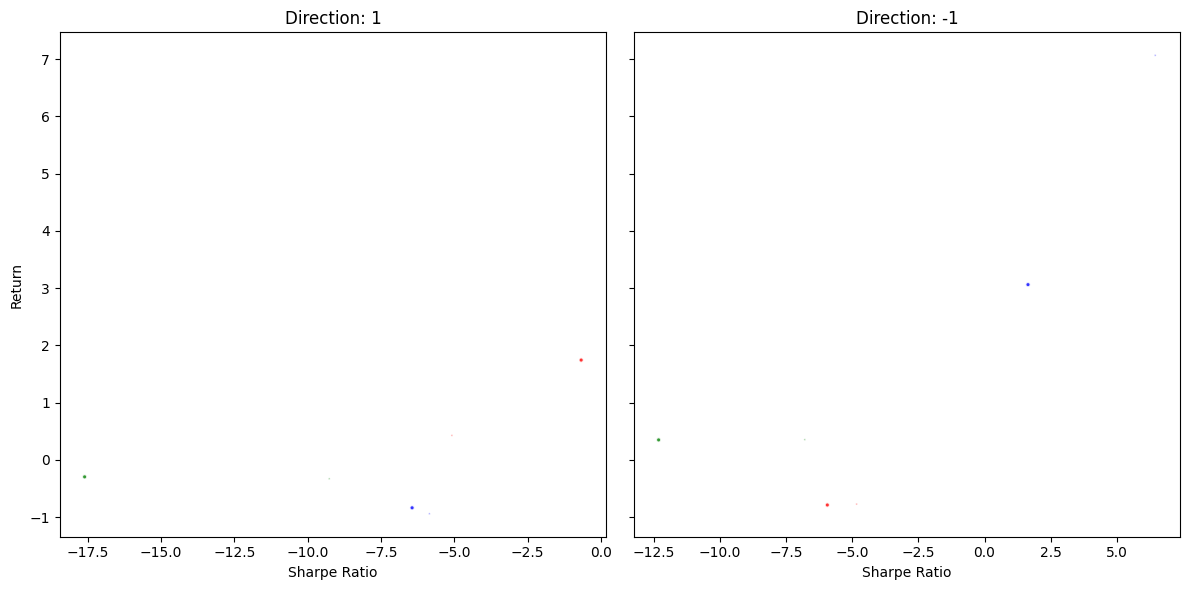

In [49]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Titles for each subplot
titles = ["Direction: 1", "Direction: -1"]

# Iterate over directions and corresponding axes
for i, direction in enumerate([1, -1]):
    d_analysis = a[a["direction"] == direction]
    axes[i].scatter(
        d_analysis["sharpe"],
        d_analysis["return"],
        c=d_analysis["color"],
        s=d_analysis["stacks"] * 2,
        alpha=0.8,
        edgecolors="w",
    )
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("Sharpe Ratio")
    axes[i].set_ylabel("Return" if i == 0 else "")  # Only label y-axis on the first plot

# Adjust layout for better spacing
plt.tight_layout()

# Show the combined plot
plt.show()

In [50]:
a.sort_values("return",ascending=False).head(20)

,direction,val,maxi,mini,stacks,risk,sharpe,return,color,return_to_risk
6,-1,1,1,0,1,2.081120,6.448520,7.068618,blue,3.396545
7,-1,1,1,0,5,0.908782,1.642666,3.062696,blue,3.370111
5,1,-1,1,0,5,0.533377,-0.674757,1.744729,red,3.271102
4,1,-1,1,0,1,0.234227,-5.080341,0.429271,red,1.832716
8,-1,0,1,0,1,0.180604,-6.791216,0.354235,green,1.961392
9,-1,0,1,0,5,0.101882,-12.316284,0.350339,green,3.438683
3,1,0,1,0,5,0.074573,-17.600066,-0.294971,green,-3.955449
2,1,0,1,0,1,0.144450,-9.263451,-0.329562,green,-2.281497
10,-1,-1,1,0,1,0.317701,-4.832620,-0.770636,red,-2.425661
11,-1,-1,1,0,5,0.250405,-5.940331,-0.786680,red,-3.141636


In [64]:
value = 1
direction = -1
maximum_index = 1
minimum_index = 0
num_stocks_per_industry = 1
stacks = rank_list(value,num_stocks_per_industry)

In [73]:
stacks = rank_list(value,num_stocks_per_industry)
# max_cap = simulation.sort_values("market_cap")["market_cap"].unique()[-maximum_index]
# min_cap = simulation.sort_values("market_cap")["market_cap"].unique()[minimum_index]
# filtered_simulation = simulation[(simulation["market_cap"]<=max_cap) & (simulation["market_cap"]>=min_cap)].copy()
trades = simulation[filtered_columns].groupby(["year","quarter","ticker"]).agg(agg_query).reset_index()
trades = trades.sort_values("rank",ascending=True).groupby(["year","quarter","market_cap_rank"]).nth(stacks).reset_index()
trades["return"] = (trades["sell_price"] - trades["adjclose"])/trades["adjclose"]
trades["return"] = trades["return"] * trades["exposure"] * direction 
trades["return"] = winsorize(trades["return"],[0.05,0.05])
trades = trades.merge(index[["ticker","name"]],how="left",on="ticker")
analysis = trades[["year","quarter","exposure","return"]].groupby(["year","quarter","exposure"]).mean().pivot_table(index=["year","quarter"],columns="exposure",values="return").reset_index()
portfolio = trades[["year","quarter","return"]].groupby(["year","quarter"]).mean().reset_index().sort_values(["year","quarter"])
portfolio["return"] = portfolio["return"] + 1
portfolio["return"] = portfolio["return"].cumprod() - 1
portfolio['Year-Quarter'] = portfolio["year"].astype(str) + "q" + portfolio["quarter"].astype(str)
portfolio = portfolio.merge(benchmark,on=["year","quarter"],how="left")

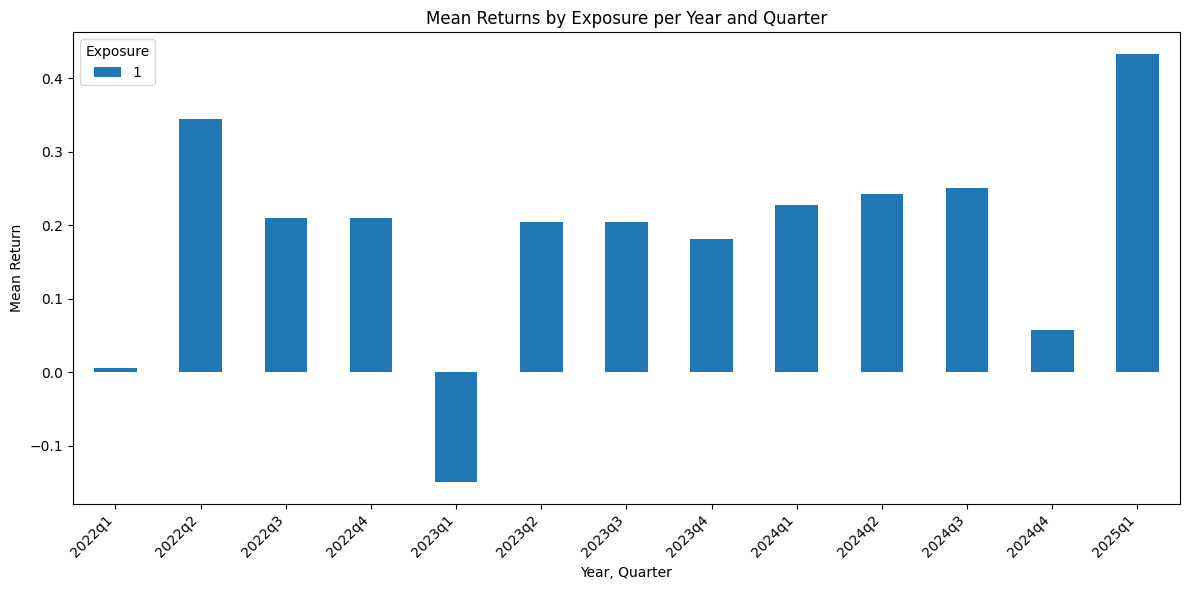

In [74]:
analysis['Year-Quarter'] = analysis["year"].astype(str) + "q" + analysis["quarter"].astype(str)

# Reset index for plotting
analysis.drop(["year","quarter"],axis=1,inplace=True)
analysis.reset_index(drop=True, inplace=True)

# Plot a bar chart
analysis.set_index("Year-Quarter").plot(
    kind="bar",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Customize the plot
plt.xlabel("Year, Quarter")
plt.ylabel("Mean Return")
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.legend(title="Exposure")
plt.tight_layout()

# Show the plot
plt.show()


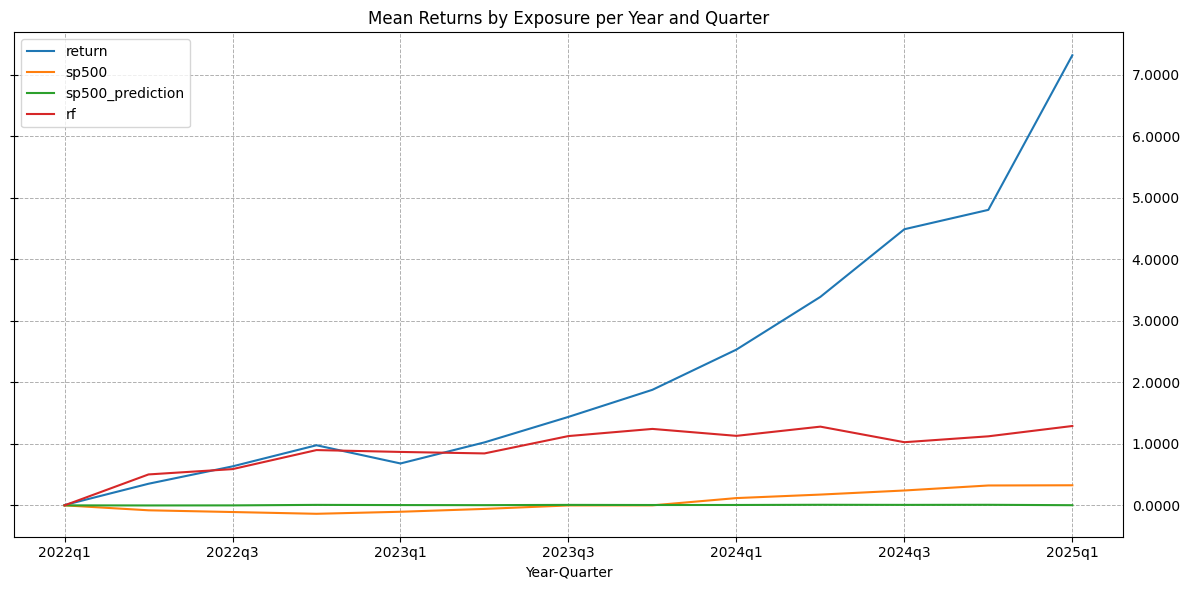

In [75]:
# Create the plot
ax = portfolio.drop(["date", "year", "quarter"], axis=1).set_index("Year-Quarter").plot(
    kind="line",
    figsize=(12, 6),
    title="Mean Returns by Exposure per Year and Quarter"
)

# Set y-axis to have more precise ticks
ax.tick_params(axis='y', direction='in', length=6)  # Adjust y-tick direction and length
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.4f}'))  # Format y-ticks with 4 decimal places

# Move y-ticks to the right side
ax.yaxis.set_tick_params(which='both', direction='inout', length=6, labelleft=False, labelright=True)

# Optionally adjust the number of ticks for better precision
ax.yaxis.set_major_locator(plt.MaxNLocator(integer=False, prune='both'))

# Add grid lines
ax.grid(True, which='both', axis='both', linestyle='--', linewidth=0.7)

# Display the plot
plt.tight_layout()
plt.show()

In [76]:
portfolio.tail()

,year,quarter,return,Year-Quarter,date,sp500,sp500_prediction,rf
8,2024,1,2.532875,2024q1,2024-02-14 09:50:09.836065536+00:00,0.118437,0.006260,1.130250
9,2024,2,3.390335,2024q2,2024-05-14 06:05:42.857142784+00:00,0.175358,0.009472,1.280080
10,2024,3,4.489923,2024q3,2024-08-15 01:52:30+00:00,0.241857,0.007774,1.026871
11,2024,4,4.804789,2024q4,2024-11-14 06:45:00+00:00,0.323305,0.009181,1.122809
12,2025,1,7.318715,2025q1,2025-02-10 18:06:47.547169792+00:00,0.326711,0.002789,1.290498


In [77]:
trades.groupby(["year","quarter","exposure","market_cap_rank"]).agg({"return":"mean"}).tail(22)

return
year quarter exposure market_cap_rank          
2024 4       1        0.0             -0.372465
                      0.1             -0.505115
                      0.2             -0.185820
                      0.3             -0.270367
                      0.4              0.222714
                      0.5              0.418873
                      0.6              0.260065
                      0.7              0.315273
                      0.8             -0.002425
                      0.9              0.438000
                      1.0              0.312155
2025 1       1        0.0              0.385562
                      0.1              0.495134
                      0.2              0.406665
                      0.3              0.147770
                      0.4              0.416904
                      0.5              0.559129
                      0.6              0.517687
                      0.7              0.334072
                      0.8              0.741933
                      0.9              0.666703
                      1.0              0.092299

In [78]:
trades[trades["year"]==2025].sort_values("return",ascending=False)

,index,year,quarter,ticker,date,sell_date,market_cap_rank,exposure,rank,adjclose,sell_price,return,name
268,51980,2025,1,CISO,2025-01-02 00:00:00+00:00,2025-03-20 00:00:00+00:00,0.1,1,2,3.0300,0.4800,0.780546,"CISO Global, Inc. Common Stock"
197,53089,2025,1,IDAI,2025-01-02 00:00:00+00:00,2025-03-20 00:00:00+00:00,0.8,1,2,10.2450,2.1500,0.780546,T Stamp Inc. Class A Common Stock
149,53665,2025,1,MNTS,2025-01-02 00:00:00+00:00,2025-03-20 00:00:00+00:00,0.9,1,2,8.2100,1.9300,0.764921,Momentus Inc. Class A Common Stock
145,53944,2025,1,NXU,2025-01-02 00:00:00+00:00,2025-03-20 00:00:00+00:00,0.5,1,2,0.9400,0.2550,0.728723,"Nxu, Inc. Class A Common Stock"
74,54875,2025,1,TANH,2025-01-02 00:00:00+00:00,2025-03-20 00:00:00+00:00,0.8,1,1,8.6120,2.5550,0.703321,Tantech Holdings Ltd. Common Stock
226,52853,2025,1,GNPX,2025-01-02 00:00:00+00:00,2025-03-20 00:00:00+00:00,0.6,1,2,0.9009,0.3754,0.583306,"Genprex, Inc. Common Stock"
84,52463,2025,1,ENSC,2025-01-02 00:00:00+00:00,2025-03-20 00:00:00+00:00,0.9,1,1,8.2500,3.5600,0.568485,"Ensysce Biosciences, Inc. Common Stock"
43,52887,2025,1,GRI,2025-01-02 00:00:00+00:00,2025-03-20 00:00:00+00:00,0.7,1,1,14.4500,7.0000,0.515571,"GRI Bio, Inc. Common Stock"
176,54380,2025,1,RDGT,2025-01-02 00:00:00+00:00,2025-03-20 00:00:00+00:00,0.0,1,2,1.8300,0.8926,0.512240,"Ridgetech, Inc. Ordinary Shares"
229,52897,2025,1,GRYP,2025-01-02 00:00:00+00:00,2025-03-20 00:00:00+00:00,0.2,1,2,0.3992,0.1980,0.504008,"Gryphon Digital Mining, Inc Common Stock"


In [79]:
print(((macro["sp500"].pct_change().cumsum().iloc[-1]+1) ** (1/6))/macro["sp500"].pct_change().cumsum().std())

4.289717553646794
